In [123]:
import pandas as pd
import zipfile
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import lzma
import json
import numpy as np
import colorcet as cc
import re
from matplotlib.ticker import ScalarFormatter


sns.set_theme(font_scale=0.81666666666666666)
plt.rc('text', usetex=True)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern']
plt.rc('text.latex', preamble=
    r'''
    \RequirePackage[T1]{fontenc}
    \RequirePackage{amsmath}
    \RequirePackage{siunitx}
    \RequirePackage[super]{nth}
    ''')

# Load compressed data

In [124]:
with lzma.open("./10_summary_data.json.xz", "rt") as f:
    summary_data = json.load(f)
summary_dataframe = pd.DataFrame(summary_data)

with lzma.open("./05_amended_outcomes.json.xz", "rt") as f:
    mes_outcome_data = json.load(f)
mes_outcomes = []
for filename, outcome in mes_outcome_data['mes_sizes'].items():
    removal_size = mes_outcome_data['removal_sizes'][filename]
    mes_outcomes.append({
        'filename': filename,
        'mes_size': outcome,
        'removal_size': removal_size
    })
mes_outcome_dataframe = pd.DataFrame(mes_outcomes)

In [125]:
NUM_SUBPROBLEMS = 500
NUM_COMBINATIONS = 13
if len(summary_dataframe) != NUM_SUBPROBLEMS * NUM_COMBINATIONS:
    print(f"WARNING: Number of rows {len(summary_dataframe)} "
          f"does not match expected value {NUM_SUBPROBLEMS * NUM_COMBINATIONS};"
          " some runs may be missing or failed!")

# Check outcome consistency
## Generate fingerprint identifying subproblems

In [126]:
fingerprint_re = re.compile(r'^solved-([^-]+)-(.+)\.json\.xz$')
amended_fingerprint_re = re.compile(r'^amended-(.+)\.json\.xz$')
def get_subproblem_fingerprint(filepath):
    path = Path(filepath)
    name = path.name
    match = fingerprint_re.match(name)
    match_index = 2
    if match is None:
        match = amended_fingerprint_re.match(name)
        match_index = 1
        if match is None:
            raise ValueError(f"Could not parse fingerprint from {name}")
    return str(path.parent / match[match_index])

In [127]:
summary_dataframe['subproblem_fingerprint'] = \
    summary_dataframe['filename'].apply(get_subproblem_fingerprint)
mes_outcome_dataframe['subproblem_fingerprint'] = \
    mes_outcome_dataframe['filename'].apply(get_subproblem_fingerprint)

## Additional data fields

In [128]:
summary_dataframe['total_time'] = summary_dataframe['build_time'] + \
        summary_dataframe['solve_time'] + summary_dataframe['mes_time']

In [129]:
summary_dataframe['mes_time'].median(), summary_dataframe['mes_time'].max()

(0.06811956499999999, 0.951599492)

## Actual consistency check, true outcome flags

In [130]:
def get_any(s):
    for item in s:
        return item

fpc = 'subproblem_fingerprint'
outcomes = summary_dataframe[[fpc, 'outcome']].groupby(fpc).agg(set)
true_outcome_info = []
for row in outcomes.itertuples():
    if len(row.outcome) == 1:
        if row.outcome == {'TIMEOUT'}:
            true_outcome_info.append({
                fpc: row.Index,
                'have_true_outcome': False,
                'true_outcome': None
            })
        else:
            true_outcome_info.append({
                fpc: row.Index,
                'have_true_outcome': True,
                'true_outcome': get_any(row.outcome)
            })
        continue
    if len(row.outcome) != 2 or 'TIMEOUT' not in row.outcome:
        raise ValueError(f"Unexpected outcome set {row.outcome}"
                         f" for {row.Index}")
    true_outcome_info.append({
        fpc: row.Index,
        'have_true_outcome': True,
        'true_outcome': get_any(row.outcome - {'TIMEOUT'})
    })
summary_dataframe_with_true_outcomes = \
    pd.DataFrame(true_outcome_info).merge(right=summary_dataframe, on=fpc)
fingerprints_with_true_outcomes = \
    pd.DataFrame(summary_dataframe_with_true_outcomes.query('have_true_outcome == True')[fpc].unique())
fingerprints_with_true_outcomes.rename(columns={0: fpc}, inplace=True)
fingerprints_improvement_found = \
    pd.DataFrame(summary_dataframe_with_true_outcomes.query('true_outcome == "IMPROVED_SOLUTION"')[fpc].unique())
fingerprints_improvement_found.rename(columns={0: fpc}, inplace=True)
fingerprints_were_optimal = \
    pd.DataFrame(summary_dataframe_with_true_outcomes.query('true_outcome == "SOLUTION_WAS_OPTIMAL"')[fpc].unique())
fingerprints_were_optimal.rename(columns={0: fpc}, inplace=True)

In [131]:
summary_dataframe[fpc].nunique(), len(fingerprints_with_true_outcomes),\
len(fingerprints_improvement_found), len(fingerprints_were_optimal)

(397, 370, 104, 266)

# MES size gaps

In [132]:
mes_outcome_dataframe['Absolute MES Gap'] = \
    mes_outcome_dataframe['removal_size'] - 1 - mes_outcome_dataframe['mes_size']
mes_outcome_dataframe['Absolute MES Gap'].max()

10

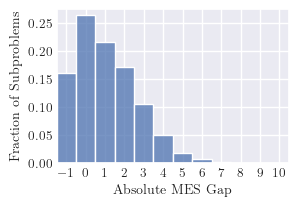

In [133]:
#abs_count = mes_outcome_dataframe['Absolute MES Gap'].value_counts()
#abs_count = pd.DataFrame(abs_count)
#abs_count.reset_index(inplace=True)
#abs_count.rename(columns={'count': 'Count'}, inplace=True)
#sns.barplot(x='Absolute MES Gap', y='Count', data=abs_count)
sns.histplot(data=mes_outcome_dataframe, x='Absolute MES Gap',
             bins=12, stat='proportion', discrete=True)
plt.gca().set_xticks([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.gca().set_yticks([0, 0.05, 0.10, 0.15, 0.20, 0.25])
plt.gca().set_xlim(-1.5, 10.5)
plt.gca().set_ylim(0, 0.275)
plt.gca().tick_params(axis='x', pad=-3)
plt.gca().tick_params(axis='y', pad=-2)
plt.gcf().set_size_inches(3.0, 2.0)
plt.gca().set_ylabel('Fraction of Subproblems')
plt.savefig('abs_mes_gap_histogram.pdf', bbox_inches='tight',
            pad_inches=0.05)

# Solved after time / cactus plot

In [134]:
solver_name_re = re.compile(r'^\s*([^()]+)\s+\(([^()]+)\)\s*$')

def approach_of(solver_name: str) -> str:
    return solver_name_re.match(solver_name)[1]
def sat_solver_of(solver_name: str) -> str:
    return solver_name_re.match(solver_name)[2]

In [135]:
def make_solved_at_time(restrict_to_fingerprints=None):
    solvers = set(summary_dataframe['solver'].unique())
    solver_num_solved = {
        solver: 0 for solver in solvers
    }
    solved_at_time = [
        {'solver': solver, 'num_solved': 0, 'time': 0.0} 
        for solver in solver_num_solved
    ]
    virtual_best_solved_at_time = [
        {'solver': 'Virtual Best', 'num_solved': 0, 'time': 0.0}
    ]
    subproblems_solved = set()
    actual_dataframe = summary_dataframe
    if restrict_to_fingerprints is not None:
        actual_dataframe = summary_dataframe.merge(
            on=fpc, how='inner', right=restrict_to_fingerprints)
    for row in actual_dataframe.sort_values('total_time').itertuples():
        if row.outcome == 'TIMEOUT':
            continue
        fp = row.subproblem_fingerprint
        if fp not in subproblems_solved:
            subproblems_solved.add(fp)
            new_solved = len(subproblems_solved)
            virtual_best_solved_at_time.append({
                'solver': 'Virtual Best',
                'num_solved': new_solved - 1,
                'time': math.nextafter(row.total_time, -math.inf)
            })
            virtual_best_solved_at_time.append({
                'solver': 'Virtual Best',
                'num_solved': new_solved,
                'time': row.total_time
            })
        num_solved_prev = solver_num_solved[row.solver]
        solver_num_solved[row.solver] += 1
        solved_at_time.append({
            'solver': row.solver,
            'num_solved': num_solved_prev,
            'time': math.nextafter(row.total_time, -math.inf)
        })
        solved_at_time.append({
            'solver': row.solver,
            'num_solved': num_solved_prev + 1,
            'time': row.total_time
        })
    for solver in solver_num_solved:
        solved_at_time.append({
            'solver': solver,
            'num_solved': solver_num_solved[solver],
            'time': 3700.0
        })
    virtual_best_solved_at_time.append({
        'solver': 'Virtual Best',
        'num_solved': len(subproblems_solved),
        'time': 3700.0
    })
    for entry in solved_at_time:
        entry['Approach'] = approach_of(entry['solver'])
        entry['SAT Solver'] = sat_solver_of(entry['solver'])
    return solved_at_time, virtual_best_solved_at_time

In [136]:
hue_order = [
    'simple incremental',
    'non-incremental',
    'greedy incremental',
    'alternating LB-UB',
    'virtual best solver'
]
style_order = [
    'CaDiCaL', 
    'CryptoMS',
    'Lingeling',
    'kissat'
]

Text(0.5, 1.0, 'higher is better')

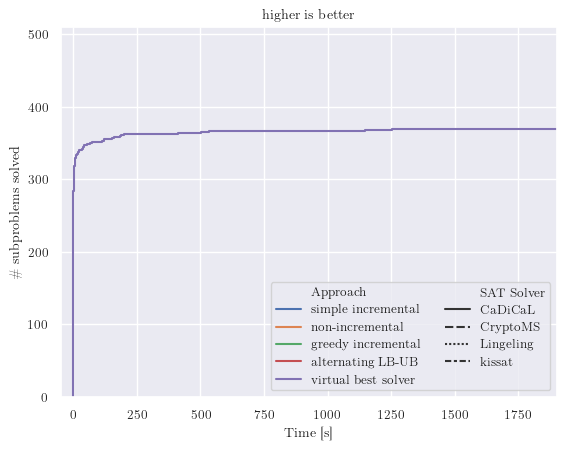

In [137]:
solved_at_time, virtual_best_solved_at_time = make_solved_at_time()
solved_at_time_df = pd.DataFrame(solved_at_time)
fig, ax = plt.gcf(), plt.gca()
sns.lineplot(data=solved_at_time_df,
             x='time', y='num_solved',
             hue='Approach', hue_order=hue_order,
             style='SAT Solver', style_order=style_order,
             ax=ax)
sns.lineplot(data=pd.DataFrame(virtual_best_solved_at_time),
             x='time', y='num_solved', legend=None, ax=ax,
             color='C4')
sns.move_legend(ax, "lower right", ncols=2)
ax.set_xlim(-50.0, 1900.0)
ax.set_ylim(0, 510)
ax.set_ylabel(r'\# subproblems solved')
ax.set_xlabel(r'Time [s]')
ax.set_title(r'higher is better')

Text(0.5, 1.0, 'higher is better')

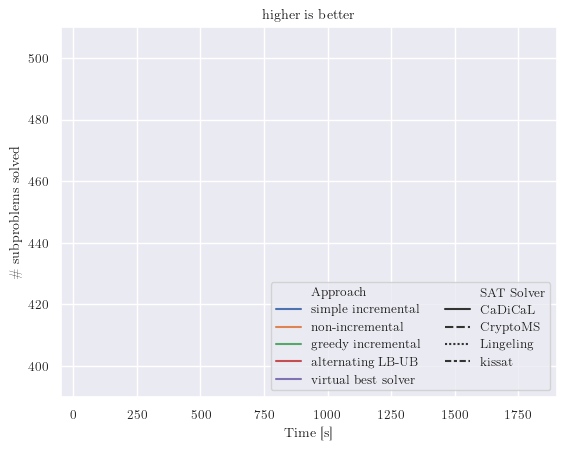

In [138]:
fig, ax = plt.gcf(), plt.gca()
sns.lineplot(data=solved_at_time_df,
             x='time', y='num_solved',
             hue='Approach', hue_order=hue_order,
             style='SAT Solver', style_order=style_order,
             ax=ax)
sns.lineplot(data=pd.DataFrame(virtual_best_solved_at_time),
             x='time', y='num_solved', legend=None, ax=ax,
             color='C4')
sns.move_legend(ax, "lower right", ncols=2)
ax.set_xlim(-50.0, 1900.0)
ax.set_ylim(390, 510)
ax.set_ylabel(r'\# subproblems solved')
ax.set_xlabel(r'Time [s]')
ax.set_title(r'higher is better')

## Only subproblems with improvement found

Text(0.5, 1.0, 'higher is better')

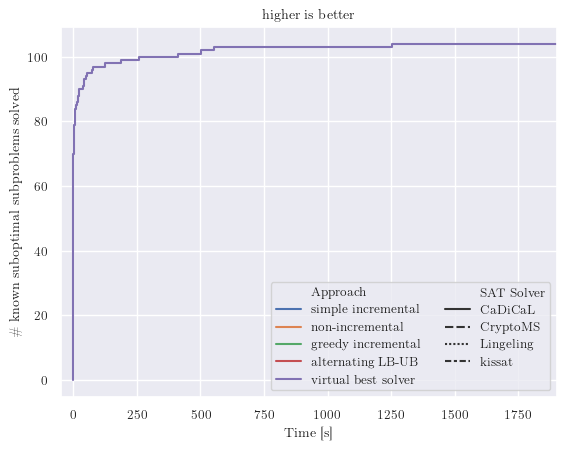

In [139]:
imp_solved_at_time, imp_virtual_best_solved_at_time = make_solved_at_time(fingerprints_improvement_found)
imp_solved_at_time_df = pd.DataFrame(imp_solved_at_time)
fig, ax = plt.gcf(), plt.gca()
sns.lineplot(data=imp_solved_at_time_df,
             x='time', y='num_solved',
             hue='Approach', hue_order=hue_order,
             style='SAT Solver', style_order=style_order,
             ax=ax)
sns.lineplot(data=pd.DataFrame(imp_virtual_best_solved_at_time),
             x='time', y='num_solved', legend=None, ax=ax,
             color='C4')
sns.move_legend(ax, "lower right", ncols=2)
ax.set_xlim(-50.0, 1900.0)
#ax.set_ylim(110, 510)
ax.set_ylabel(r'\# known suboptimal subproblems solved')
ax.set_xlabel(r'Time [s]')
ax.set_title(r'higher is better')

## Only subproblems that were optimal

Text(0.5, 1.0, 'higher is better')

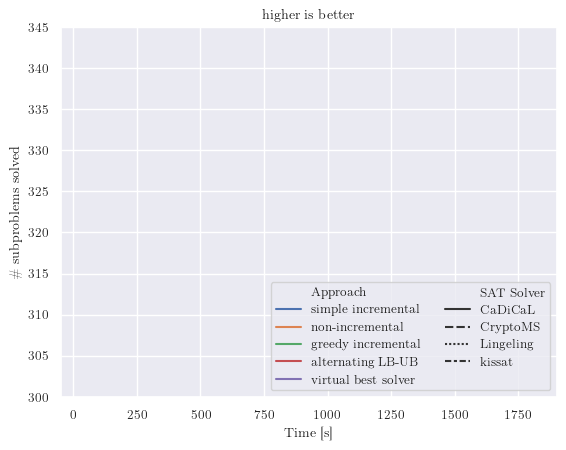

In [140]:
opt_solved_at_time, opt_virtual_best_solved_at_time = make_solved_at_time(fingerprints_were_optimal)
opt_solved_at_time_df = pd.DataFrame(opt_solved_at_time)
fig, ax = plt.gcf(), plt.gca()
sns.lineplot(data=opt_solved_at_time_df,
             x='time', y='num_solved',
             hue='Approach', hue_order=hue_order,
             style='SAT Solver', style_order=style_order,
             ax=ax)
sns.lineplot(data=pd.DataFrame(opt_virtual_best_solved_at_time),
             x='time', y='num_solved', legend=None, ax=ax,
             color='C4')
sns.move_legend(ax, "lower right", ncols=2)
ax.set_xlim(-50.0, 1900.0)
ax.set_ylim(300, 345)
ax.set_ylabel(r'\# subproblems solved')
ax.set_xlabel(r'Time [s]')
ax.set_title(r'higher is better')

# Overall figure

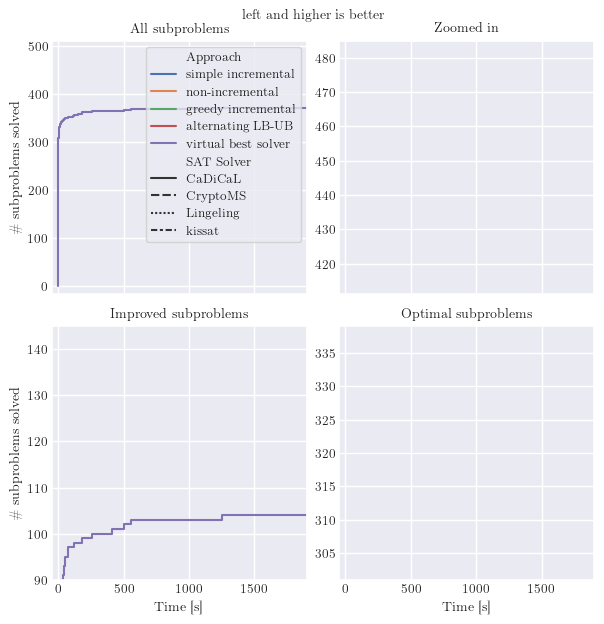

In [141]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 7))
plt.subplots_adjust(wspace=0.125, hspace=0.125)
fig.suptitle('left and higher is better', fontsize=10, y=0.925)

# Axis 1
ax1.set_title(r'All subproblems')
sns.lineplot(data=solved_at_time_df,
             x='time', y='num_solved',
             hue='Approach', hue_order=hue_order,
             style='SAT Solver', style_order=style_order,
             ax=ax1)
sns.lineplot(data=pd.DataFrame(virtual_best_solved_at_time),
             x='time', y='num_solved', legend=None,
             color='C4', ax=ax1)
ax1.set_ylim(ax1.get_ylim()[0], 510)
ax1.sharex(ax3)
ax1.set_xlabel(None)
ax1.set_ylabel(r'\# subproblems solved')
ax1.tick_params(axis='y', pad=-3)

# Axis 2
ax2.set_title(r'Zoomed in')
sns.lineplot(data=solved_at_time_df,
             x='time', y='num_solved',
             hue='Approach', hue_order=hue_order, legend=None,
             style='SAT Solver', style_order=style_order,
             ax=ax2)
sns.lineplot(data=pd.DataFrame(virtual_best_solved_at_time),
             x='time', y='num_solved', legend=None,
             color='C4', ax=ax2)
ax2.sharex(ax4)
ax2.set_ylim(411, 485)
ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax2.tick_params(axis='y', pad=-3)

# Axis 3
ax3.set_title(r'Improved subproblems')
imp_solved_at_time, imp_virtual_best_solved_at_time = \
    make_solved_at_time(fingerprints_improvement_found)
imp_solved_at_time_df = pd.DataFrame(imp_solved_at_time)
sns.lineplot(data=imp_solved_at_time_df,
             x='time', y='num_solved',
             hue='Approach', hue_order=hue_order,
             style='SAT Solver', style_order=style_order,
             ax=ax3, legend=None)
sns.lineplot(data=pd.DataFrame(imp_virtual_best_solved_at_time),
             x='time', y='num_solved', legend=None, ax=ax3,
             color='C4')
ax3.set_xlim(-50.0, 1900.0)
ax3.set_ylim(90, 145)
ax3.tick_params(axis='x', pad=-3)
ax3.tick_params(axis='y', pad=-3)
ax3.set_xlabel(r'Time [s]')
ax3.set_ylabel(r'\# subproblems solved')

# Axis 4
ax4.set_title(r'Optimal subproblems')
opt_solved_at_time, opt_virtual_best_solved_at_time = \
    make_solved_at_time(fingerprints_were_optimal)
opt_solved_at_time_df = pd.DataFrame(opt_solved_at_time)
sns.lineplot(data=opt_solved_at_time_df,
             x='time', y='num_solved',
             hue='Approach', hue_order=hue_order,
             style='SAT Solver', style_order=style_order,
             ax=ax4, legend=None)
sns.lineplot(data=pd.DataFrame(opt_virtual_best_solved_at_time),
             x='time', y='num_solved', legend=None, ax=ax4,
             color='C4')
ax4.set_xlim(-50.0, 1900.0)
ax4.set_ylim(301, 339)
ax4.set_ylabel(None)
ax4.set_xlabel(r'Time [s]')
ax4.tick_params(axis='x', pad=-3)
ax4.tick_params(axis='y', pad=-3)

# Hide x-ticks on the top row
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.savefig('subproblem_solver_comparison.pdf', bbox_inches='tight',
            pad_inches=0.01)

## Runtime by MES gap

In [142]:
small_gap = pd.DataFrame(mes_outcome_dataframe[mes_outcome_dataframe['Absolute MES Gap'] <= 1]['subproblem_fingerprint'].unique())
small_gap.rename(columns={0: fpc}, inplace=True)

In [143]:
medium_gap = pd.DataFrame(mes_outcome_dataframe[(mes_outcome_dataframe['Absolute MES Gap'] > 1) & (mes_outcome_dataframe['Absolute MES Gap'] <= 3)]['subproblem_fingerprint'].unique())
medium_gap.rename(columns={0: fpc}, inplace=True)

In [144]:
large_gap = pd.DataFrame(mes_outcome_dataframe[mes_outcome_dataframe['Absolute MES Gap'] > 3]['subproblem_fingerprint'].unique())
large_gap.rename(columns={0: fpc}, inplace=True)

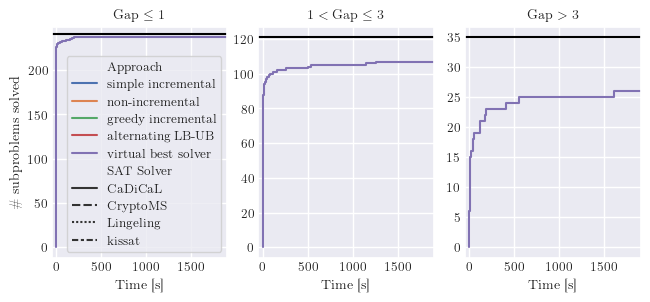

In [145]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(7.6, 3))
plt.subplots_adjust(wspace=0.175, hspace=None)
g1_solved_at_time, g1_virtual_best_solved_at_time = \
    make_solved_at_time(small_gap)
g1_solved_at_time_df = pd.DataFrame(g1_solved_at_time)
sns.lineplot(data=g1_solved_at_time_df,
                x='time', y='num_solved',
                hue='Approach', hue_order=hue_order,
                style='SAT Solver', style_order=style_order,
                ax=ax1)
sns.lineplot(data=pd.DataFrame(g1_virtual_best_solved_at_time),
                x='time', y='num_solved',
                legend=None, ax=ax1,
                color='C4')
for axis in (ax1, ax2, ax3):
    axis.tick_params(axis='x', pad=-3)
    axis.tick_params(axis='y', pad=-3)
ax1.set_title(r'Gap $\leq 1$')
ax1.set_xlabel(r'Time [s]')
ax1.set_xlim(-50.0, 1900.0)
ax1.set_ylabel(r'\# subproblems solved')
num_small_gap = summary_dataframe.merge(
    on=fpc, how='inner', right=small_gap)[fpc].nunique()
num_medium_gap = summary_dataframe.merge(
    on=fpc, how='inner', right=medium_gap)[fpc].nunique()
num_large_gap = summary_dataframe.merge(
    on=fpc, how='inner', right=large_gap)[fpc].nunique()
ax1.axhline(y=num_small_gap, color='black')
sns.move_legend(ax1, "lower right")

g2_solved_at_time, g2_virtual_best_solved_at_time = \
    make_solved_at_time(medium_gap)
g2_solved_at_time_df = pd.DataFrame(g2_solved_at_time)
sns.lineplot(data=g2_solved_at_time_df,
                x='time', y='num_solved',
                hue='Approach', hue_order=hue_order,
                style='SAT Solver', style_order=style_order,
                legend=None,
                ax=ax2)
sns.lineplot(data=pd.DataFrame(g2_virtual_best_solved_at_time),
                x='time', y='num_solved',
                legend=None, ax=ax2,
                color='C4')
ax2.set_title(r'$1 < \mathrm{Gap} \leq 3$')
ax2.set_xlabel(r'Time [s]')
ax2.set_xlim(-50.0, 1900.0)
ax2.set_ylabel(None)
ax2.axhline(y=num_medium_gap, color='black')

g3_solved_at_time, g3_virtual_best_solved_at_time = \
    make_solved_at_time(large_gap)
g3_solved_at_time_df = pd.DataFrame(g3_solved_at_time)
sns.lineplot(data=g3_solved_at_time_df,
                x='time', y='num_solved',
                hue='Approach', hue_order=hue_order,
                style='SAT Solver', style_order=style_order,
                legend=None,
                ax=ax3)
sns.lineplot(data=pd.DataFrame(g3_virtual_best_solved_at_time),
                x='time', y='num_solved',
                legend=None, ax=ax3,
                color='C4')
ax3.set_title(r'Gap $> 3$')
ax3.set_xlabel(r'Time [s]')
ax3.set_xlim(-50.0, 1900.0)
ax3.set_ylabel(None)
ax3.axhline(y=num_large_gap, color='black')
plt.savefig('subproblem_solver_comparison_by_gap.pdf', bbox_inches='tight',
            pad_inches=0.01)